# Background Remvoal with SVD

**Our goal today**: ![background removal](images/surveillance3.png)

### Load and Format the Data

Let's use the real video 003 dataset from [BMC 2012 Background Models Challenge Dataset](http://bmc.iut-auvergne.com/?page_id=24)

Import needed libraries:

In [1]:
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.


Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 

8192/45929032 bytes (0.0%)

729088/45929032 bytes (1.6%)

2023424/45929032 bytes (4.4%)

3858432/45929032 bytes (8.4%)

6520832/45929032 bytes (14.2%)

9117696/45929032 bytes (19.9%)

11558912/45929032 bytes (25.2%)

14106624/45929032 bytes (30.7%)

16637952/45929032 bytes (36.2%)

19169280/45929032 bytes (41.7%)

21577728/45929032 bytes (47.0%)

24141824/45929032 bytes (52.6%)

26853376/45929032 bytes (58.5%)

29638656/45929032 bytes (64.5%)

32456704/45929032 bytes (70.7%)

35282944/45929032 bytes (76.8%)

38035456/45929032 bytes (82.8%)

40894464/45929032 bytes (89.0%)

43180032/45929032 bytes (94.0%)

45929032/45929032 bytes (100.0%)

  Done


File saved as /home/user/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1.


In [2]:
import moviepy.editor as mpe
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
np.set_printoptions(precision=4, suppress=True)

In [5]:
video = mpe.VideoFileClip("Fastai 1 and 2/Video_003.avi")

In [6]:
video.subclip(0,50).ipython_display(width=300)

  0%|          | 0/351 [00:00<?, ?it/s]

 10%|▉         | 34/351 [00:00<00:00, 336.19it/s]

 16%|█▌        | 55/351 [00:00<00:01, 271.35it/s]

 26%|██▌       | 92/351 [00:00<00:00, 303.60it/s]

 38%|███▊      | 133/351 [00:00<00:00, 329.97it/s]

 46%|████▌     | 160/351 [00:00<00:00, 310.63it/s]

 53%|█████▎    | 186/351 [00:00<00:00, 282.84it/s]

 62%|██████▏   | 219/351 [00:00<00:00, 288.79it/s]

 72%|███████▏  | 254/351 [00:00<00:00, 295.77it/s]

 82%|████████▏ | 289/351 [00:00<00:00, 301.42it/s]

 91%|█████████ | 320/351 [00:01<00:00, 300.38it/s]

100%|█████████▉| 350/351 [00:01<00:00, 299.61it/s]

In [7]:
video.duration

113.57

### Helper Methods

In [8]:
def create_data_matrix_from_video(clip, fps=5, scale=50):
    return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(fps))).astype(int), 
                      scale).flatten() for i in range(fps * int(clip.duration))]).T

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

### Format the Data

An image from 1 moment in time is 120 pixels by 160 pixels (when scaled). We can *unroll* that picture into a single tall column. So instead of having a 2D picture that is $120 \times 160$, we have a $1 \times 19,200$ column 

This isn't very human-readable, but it's handy because it lets us stack the images from different times on top of one another, to put a video all into 1 matrix.  If we took the video image every hundredth of a second for 100 seconds (so 10,000 different images, each from a different point in time), we'd have a $10,000 \times 19,200$ matrix, representing the video! 

In [10]:
scale = 0.50   # Adjust scale to change resolution of image
dims = (int(240 * scale), int(320 * scale))
fps = 60      # frames per second

In [11]:
M = create_data_matrix_from_video(video.subclip(0,100), fps, scale)
# M = np.load("movie/med_res_surveillance_matrix_60fps.npy")

In [12]:
print(dims, M.shape)

(120, 160) (19200, 6000)


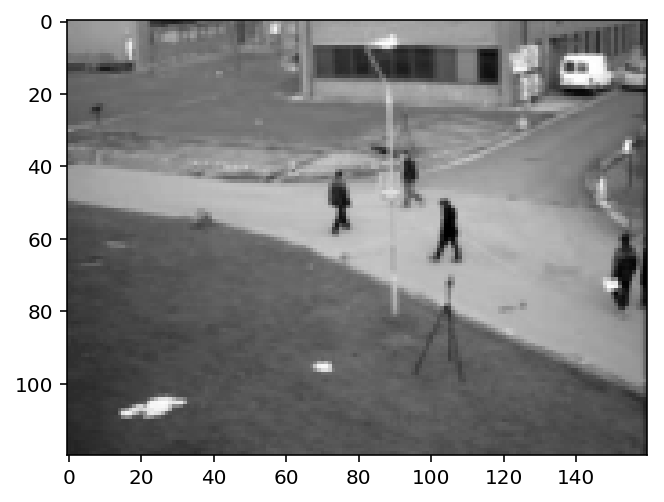

In [13]:
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

Since `create_data_from_matrix` is somewhat slow, we will save our matrix.  In general, whenever you have slow pre-processing steps, it's a good idea to save the results for future use.

In [17]:
np.save("movie/med_res_surveillance_matrix_60fps.npy", M)

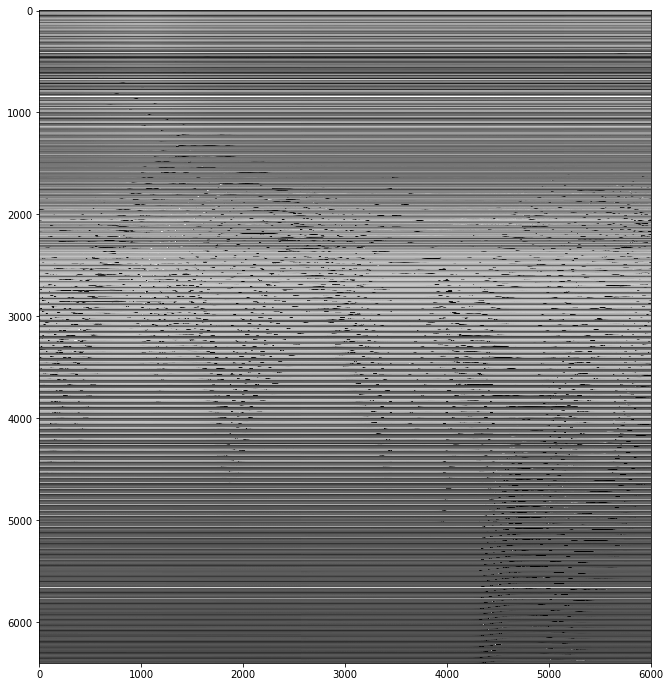

In [18]:
plt.figure(figsize=(12, 12))
plt.imshow(M[::3,:], cmap='gray')

**Questions**: What are those wavy black lines?  What are the horizontal lines?

## Singular Value Decomposition

### Intro to SVD

“a convenient way for breaking a matrix into simpler, meaningful pieces we care about” – [David Austin](http://www.ams.org/samplings/feature-column/fcarc-svd)

“the most important linear algebra concept I don’t remember learning” - [Daniel Lemire](http://lemire.me/blog/2010/07/05/the-five-most-important-algorithms/)

**Applications of SVD**:
- Principal Component Analysis
- Data compression
- Pseudo-inverse
- Collaborative Filtering
- Topic Modeling
- Background Removal
- Removing Corrupted Data

In [19]:
U, s, V = np.linalg.svd(M, full_matrices=False)

This is really slow, so you may want to save your result to use in the future.

In [22]:
#np.save("movie/U.npy", U)
#np.save("movie/s.npy", s)
np.save("c:/temp/V.npy", V) # movie/V.npy", V)

In the future, you can just load what you've saved:

In [25]:
U = np.load("movie/U.npy")
s = np.load("movie/s.npy")
V = np.load("movie/V.npy")

What do $U$, $S$, and $V$ look like?

In [23]:
U.shape, s.shape, V.shape

((19200, 6000), (6000,), (6000, 6000))

#### Exercise

Check that they are a decomposition of M

In [33]:
from scipy import linalg as la
np.allclose( U @ la.diagsvd(s,*V.shape) @ V.T, M)

False

In [33]:
#Exercise: 


True

They are! :-)

In [32]:
np.allclose(M, reconstructed_matrix)

True

In [32]:
np.set_printoptions(suppress=True, precision=0)

#### Properties of S

s is the diagonal of a *diagonal matrix*

In [34]:
np.diag(s[:6])

array([[1341719.6552,       0.    ,       0.    ,       0.    ,
              0.    ,       0.    ],
       [      0.    ,   40230.8421,       0.    ,       0.    ,
              0.    ,       0.    ],
       [      0.    ,       0.    ,   35092.2751,       0.    ,
              0.    ,       0.    ],
       [      0.    ,       0.    ,       0.    ,   30997.4195,
              0.    ,       0.    ],
       [      0.    ,       0.    ,       0.    ,       0.    ,
          28219.8891,       0.    ],
       [      0.    ,       0.    ,       0.    ,       0.    ,
              0.    ,   27196.0702]])

Do you see anything about the order for $s$?

In [35]:
s[0:2000:50]

array([1341719.6552,   10527.5148,    6162.0638,    4234.9367,
          3174.0389,    2548.4273,    2138.1887,    1812.9873,
          1557.7163,    1345.805 ,    1163.2866,    1000.5186,
           841.4604,     665.7271,       0.    ,       0.    ,
             0.    ,       0.    ,       0.    ,       0.    ,
             0.    ,       0.    ,       0.    ,       0.    ,
             0.    ,       0.    ,       0.    ,       0.    ,
             0.    ,       0.    ,       0.    ,       0.    ,
             0.    ,       0.    ,       0.    ,       0.    ,
             0.    ,       0.    ,       0.    ,       0.    ])

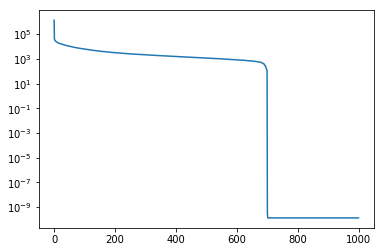

In [39]:
plt.plot(s[:1000])
plt.yscale('log')

In [41]:
len(s)

6000

In [42]:
s[700]

3.2498835534752545e-10

In [43]:
np.set_printoptions(suppress=True, precision=4)

$U$ is a giant matrix, so let's just look at a tiny bit of it:

In [44]:
U[:5,:5]

array([[-0.0083, -0.0009, -0.0007,  0.003 , -0.0002],
       [-0.0083, -0.0013, -0.0005,  0.0034, -0.0001],
       [-0.0084, -0.0012,  0.0002,  0.0045, -0.0003],
       [-0.0085, -0.0011,  0.0001,  0.0044, -0.    ],
       [-0.0086, -0.0013, -0.0002,  0.004 ,  0.0001]])

### Finding the background

In [45]:
U.shape, s.shape, V.shape

((19200, 6000), (6000,), (6000, 6000))

In [46]:
low_rank = np.expand_dims(U[:,0], 1) * s[0] * np.expand_dims(V[0,:], 0)

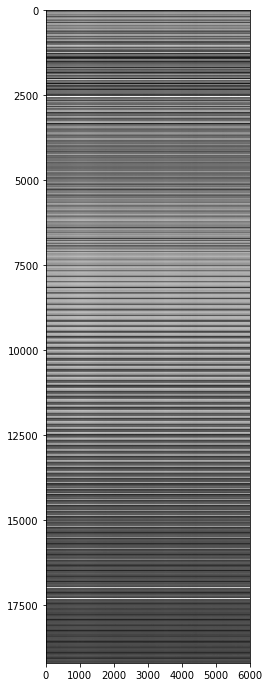

In [47]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

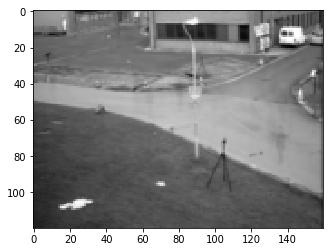

In [48]:
plt.imshow(np.reshape(low_rank[:,0], dims), cmap='gray');

How do we get the people from here?

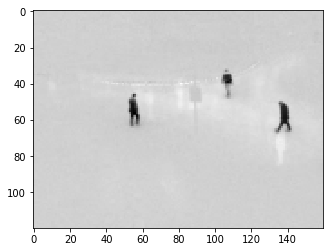

In [49]:
plt.imshow(np.reshape(M[:,0] - low_rank[:,0], dims), cmap='gray');

High-resolution version

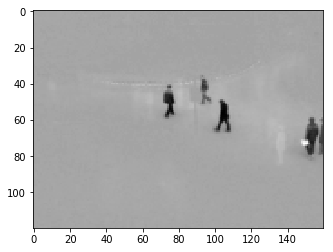

In [50]:
plt.imshow(np.reshape(M[:,140] - low_rank[:,140], dims), cmap='gray');

#### Make Video

I was inspired by [the work of fast.ai student Samir Moussa](http://forums.fast.ai/t/part-3-background-removal-with-robust-pca/4286) to make videos of the people.

In [51]:
from moviepy.video.io.bindings import mplfig_to_npimage

In [54]:
def make_video(matrix, dims, filename):
    mat_reshaped = np.reshape(matrix, (dims[0], dims[1], -1))
    
    fig, ax = plt.subplots()
    def make_frame(t):
        ax.clear()
        ax.imshow(mat_reshaped[...,int(t*fps)])
        return mplfig_to_npimage(fig)
    
    animation = mpe.VideoClip(make_frame, duration=int(10))
    animation.write_videofile('c:/temp/' + filename + '.mp4', fps=fps)

[MoviePy] >>>> Building video c:/temp/figures2.mp4
[MoviePy] Writing video c:/temp/figures2.mp4


100%|███████████████████████████████████████████████████████████████████████████████▊| 600/601 [00:25<00:00, 23.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: c:/temp/figures2.mp4 



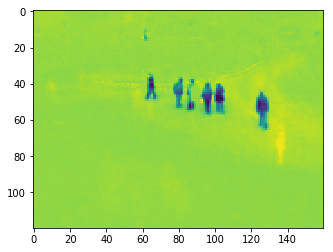

In [55]:
make_video(M - low_rank, dims, "figures2")

In [56]:
mpe.VideoFileClip("c:/temp/figures2.mp4").subclip(0,10).ipython_display(width=300)

100%|██████████████████████████████████████████████████████████████████████████████▊| 600/601 [00:00<00:00, 834.98it/s]


### Speed of SVD for different size matrices

In [4]:
import timeit
import pandas as pd

In [5]:
m_array = np.array([100, int(1e3), int(1e4)])
n_array = np.array([100, int(1e3), int(1e4)])

In [6]:
index = pd.MultiIndex.from_product([m_array, n_array], names=['# rows', '# cols'])

In [7]:
pd.options.display.float_format = '{:,.3f}'.format
df = pd.DataFrame(index=m_array, columns=n_array)

In [10]:
# %%prun
for m in m_array:
    for n in n_array:      
        A = np.random.uniform(-40,40,[m,n])  
        t = timeit.timeit('np.linalg.svd(A, full_matrices=False)', number=3, globals=globals())
        df.set_value(m, n, t)

In [12]:
df/3

,100,1000,10000
100,0.006,0.009,0.043
1000,0.004,0.259,0.992
10000,0.019,0.984,218.726


### 2 Backgrounds in 1 Video

We'll now use real video 008 dataset from [BMC 2012 Background Models Challenge Dataset](http://bmc.iut-auvergne.com/?page_id=24), in addition to video 003 that we used above.

In [34]:
from moviepy.editor import concatenate_videoclips

In [39]:
video2 = mpe.VideoFileClip("movie/Video_008.avi")

In [40]:
concat_video = concatenate_videoclips([video2.subclip(0,20), video.subclip(0,10)])
concat_video.write_videofile("movie/concatenated_video.mp4")

[MoviePy] >>>> Building video movie/concatenated_video.mp4
[MoviePy] Writing video movie/concatenated_video.mp4


100%|█████████▉| 300/301 [00:00<00:00, 481.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/concatenated_video.mp4 



In [35]:
concat_video = mpe.VideoFileClip("movie/concatenated_video.mp4")

### Now back to our background removal problem:

In [41]:
concat_video.ipython_display(width=300, maxduration=160)

100%|█████████▉| 300/301 [00:00<00:00, 533.88it/s]


In [42]:
scale = 0.5   # Adjust scale to change resolution of image
dims = (int(240 * scale), int(320 * scale))

In [43]:
N = create_data_matrix_from_video(concat_video, fps, scale)
# N = np.load("low_res_traffic_matrix.npy")

In [44]:
np.save("med_res_concat_video.npy", N)

In [45]:
N.shape

(19200, 1800)

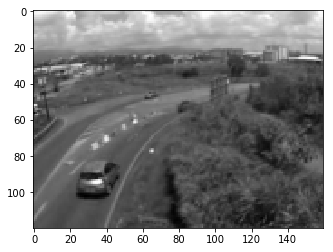

In [46]:
plt.imshow(np.reshape(N[:,200], dims), cmap='gray');

In [47]:
U_concat, s_concat, V_concat = np.linalg.svd(N, full_matrices=False)

This is slow, so you may want to save your result to use in the future.

In [48]:
np.save("movie/U_concat.npy", U_concat)
np.save("movie/s_concat.npy", s_concat)
np.save("movie/V_concat.npy", V_concat)

In the future, you can just load what you've saved:

In [49]:
U_concat = np.load("movie/U_concat.npy")
s_concat = np.load("movie/s_concat.npy")
V_concat = np.load("movie/V_concat.npy")

In [50]:
low_rank = U_concat[:,:10] @ np.diag(s_concat[:10]) @ V_concat[:10,:]

The top few components of U:

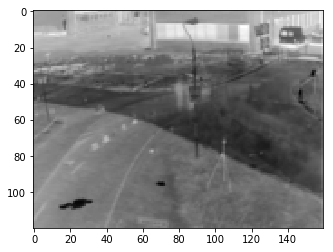

In [51]:
plt.imshow(np.reshape(U_concat[:, 1], dims), cmap='gray')

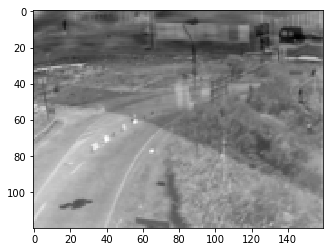

In [52]:
plt.imshow(np.reshape(U_concat[:, 2], dims), cmap='gray')

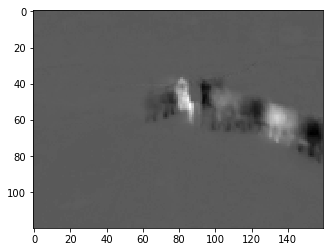

In [53]:
plt.imshow(np.reshape(U_concat[:, 3], dims), cmap='gray')

Background removal:

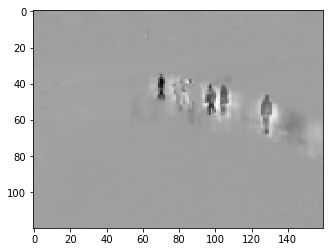

In [54]:
plt.imshow(np.reshape((N - low_rank)[:, -40], dims), cmap='gray')

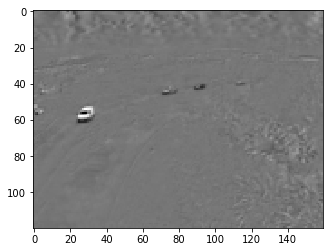

In [55]:
plt.imshow(np.reshape((N - low_rank)[:, 240], dims), cmap='gray')

### Aside about data compression

Suppose we take 700 singular values (remember, there are 10000 singular values total)

In [56]:
s[0:1000:50]

array([ 1341719.6552,    10527.5148,     6162.0638,     4234.9367,
           3174.0389,     2548.4273,     2138.1887,     1812.9873,
           1557.7163,     1345.805 ,     1163.2866,     1000.5186,
            841.4604,      665.7271,        0.    ,        0.    ,
              0.    ,        0.    ,        0.    ,        0.    ])

In [57]:
k = 700
compressed_M = U[:,:k] @ np.diag(s[:k]) @ V[:k,:]

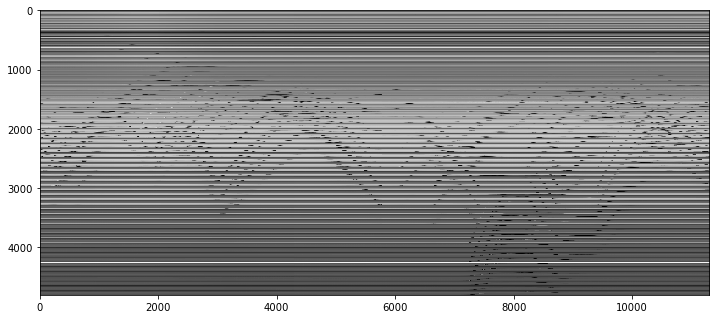

In [66]:
plt.figure(figsize=(12, 12))
plt.imshow(compressed_M, cmap='gray')

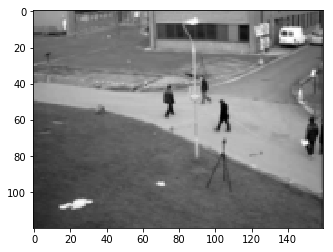

In [58]:
plt.imshow(np.reshape(compressed_M[:,140], dims), cmap='gray');

In [59]:
np.allclose(compressed_M, M)

True

In [60]:
np.linalg.norm(M - compressed_M)

2.864899899979104e-09

In [61]:
U[:,:k].shape, s[:k].shape, V[:k,:].shape

((19200, 700), (700,), (700, 6000))

space saved = data in U, s, V for 700 singular values / original matrix

In [50]:
((19200 + 1 + 6000) * 700) / (19200 * 6000)

0.1531310763888889

We only need to store 15.3% as much data and can keep the accuracy to 1e-5!  That's great!

### That's pretty neat!!! but...

The runtime complexity for SVD is $\mathcal{O}(\text{min}(m^2 n,\; m n^2))$

**Downside: this was really slow (also, we threw away a lot of our calculation)**

In [51]:
%time u, s, v = np.linalg.svd(M, full_matrices=False)

CPU times: user 5min 38s, sys: 1.53 s, total: 5min 40s
Wall time: 57.1 s


In [52]:
M.shape

(19200, 6000)